# Premier League Historical Match Result Prediction

We are proud to present you with a multi-class classification challenge on predicting Premier League match results from August 2003 up until November 2022. This is a great opportunity to experiment with and learn about a variety of core concepts in machine learning and their implementation using [scikit-learn](https://scikit-learn.org/stable/index.html).

This Jupyter notebook will guide you through the various general stages involved in end-to-end machine learning projects, including data visualisation, data preprocessing, model selection, model training and model evaluation. Finally, you will be able to submit your test set predictions to [DOXA](https://doxaai.com/).

If you do not already have a DOXA account, you will want to [sign up](https://doxaai.com/sign-up) first before proceeding and then make sure you are enrolled on the [DOXA challenge page](https://doxaai.com/competition/epl).

<img alt="Premier League" src="https://ajira.anzimag.com/wp-content/uploads/2022/08/5-8.png" width=500>

**Background**: The Premier League is a professional association football league established in 1992. It forms the highest level in the English football league system and is the most highly viewed sports league in the world.

The league contains 20 clubs, and during a Premier League season, each club plays one home and one away match with every other team in the league. As a result, every team plays 38 matches each season. A match victory gives the winning team three points in the standings, while a draw hands both teams one point each.

At the end of each season, the three worst-performing teams are relegated to the first division of the English Football League (EFL) &ndash; the EFL Championship &ndash; and the top three EFL Championship teams are promoted to the Premier League in their place.

**Objective**: The main objective for this challenge is to predict the result of a past Premier League match given some information about how the home and away teams performed during the match.

**Dataset**: We have sourced and aggregated match information dating back to August 2003 from [football-data.co.uk](https://www.football-data.co.uk/englandm.php).

## Machine Learning Workflow

![title](https://miro.medium.com/max/1400/0*V0GyOt3LoDVfY7y5.png)

The overall machine learning process covers a wide sequence of steps, so as you go through this notebook, try to keep in mind which stage are we dealing with and what we are trying to achieve. There are a lot of helpful resources online you can use, such as the excellent [scikit-learn documentation](https://scikit-learn.org/stable/getting_started.html). You are also more than welcome to ask questions in the [DOXA Community Discord server](https://discord.gg/MUvbQ3UYcf)!

## Installing and Importing Useful Packages

To get started, we will install a number of common machine learning packages.

In [1]:
%pip install numpy pandas matplotlib seaborn scikit-learn doxa-cli ipympl

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import potentially useful scikit-learn modules
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    BaggingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.svm import SVC, SVR, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

pd.set_option("display.max_colwidth", None)

%matplotlib widget

## Data Loading

In [3]:
# Download the dataset if we don't already have it!
if not os.path.exists("data"):
    os.makedirs("data", exist_ok=True)

    !curl https://raw.githubusercontent.com/DoxaAI/epl-getting-started/main/data/train.csv --output data/train.csv
    !curl https://raw.githubusercontent.com/DoxaAI/epl-getting-started/main/data/test.csv --output data/test.csv

In [4]:
# Import the training dataset
train_df_original = pd.read_csv(
    "./data/train.csv", parse_dates=["date"]
)  # Change the path accordingly

# Import the testing dataset
test_df = pd.read_csv(
    "./data/test.csv", parse_dates=["date"]
)  # Change the path accordingly

In [5]:
# We can then make an in-memory copy of the training set to manipulate
# and process while leaving the original intact as we experiment
train_df = train_df_original.copy()

## Data Understanding 

Before we dive straight into training our machine learning model, it is important to first examine and understand the dataset with which we will be working. This will provide some key insights into what sorts of data preprocessing techniques and model types might be suitable for this problem, amongst other things.

### The training set

We will start by taking a look at the training data we have available to us by looking at the first couple entries in our dataframe.

In [6]:
# Examine the first 5 entries of our dataset
train_df.head()

,date,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,half_time_home_goals,half_time_away_goals,half_time_result,referee,...,home_shots_on_target,away_shots_on_target,home_fouls,away_fouls,home_corners,away_corners,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards
0,2003-08-16,Arsenal,Everton,2,1,H,1,0,H,M Halsey,...,5,7,8,15,6,9,1,3,1,1
1,2003-08-16,Fulham,Middlesbrough,3,2,H,1,1,D,G Poll,...,9,5,18,16,7,6,1,1,0,0
2,2003-08-16,Birmingham,Tottenham,1,0,H,1,0,H,R Styles,...,5,7,20,27,1,4,3,5,0,0
3,2003-08-16,Portsmouth,Aston Villa,2,1,H,1,0,H,G Barber,...,3,5,18,22,7,9,2,1,0,1
4,2003-08-16,Man United,Bolton,4,0,H,1,0,H,P Durkin,...,6,5,12,8,8,4,0,4,0,0


So far, so good &ndash; nothing looks absurdly outlandish, so we are probably safe to continue!

As part of our analysis, it can be useful to find out the following things: what columns we have, what they represent and their datatypes; how many entries there are; and whether there are any missing values in our training dataset we might have to handle (e.g. by dropping the rows they are in or imputing the missing values).

In [7]:
# Display information about our training dataframe
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6630 entries, 0 to 6629
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  6630 non-null   datetime64[ns]
 1   home_team             6630 non-null   object        
 2   away_team             6630 non-null   object        
 3   full_time_home_goals  6630 non-null   int64         
 4   full_time_away_goals  6630 non-null   int64         
 5   full_time_result      6630 non-null   object        
 6   half_time_home_goals  6630 non-null   int64         
 7   half_time_away_goals  6630 non-null   int64         
 8   half_time_result      6630 non-null   object        
 9   referee               6630 non-null   object        
 10  home_shots            6630 non-null   int64         
 11  away_shots            6630 non-null   int64         
 12  home_shots_on_target  6630 non-null   int64         
 13  away_shots_on_targ

Nice &ndash; it looks like we have **6630 entries** with **22 columns** (including our output label `full_time_result`), representing both numerical and categorical data, as well as no missing values! 

If you prefer, you can also confirm that there are no missing values another way:

In [8]:
# Count how many missing values there are for each column
train_df.isna().sum()

date                    0
home_team               0
away_team               0
full_time_home_goals    0
full_time_away_goals    0
full_time_result        0
half_time_home_goals    0
half_time_away_goals    0
half_time_result        0
referee                 0
home_shots              0
away_shots              0
home_shots_on_target    0
away_shots_on_target    0
home_fouls              0
away_fouls              0
home_corners            0
away_corners            0
home_yellow_cards       0
away_yellow_cards       0
home_red_cards          0
away_red_cards          0
dtype: int64

We can also take a look at a few summary statistics for the different numerical columns in our dataframe.

In [9]:
# View some statistical information about the features we have
train_df.describe()

,full_time_home_goals,full_time_away_goals,half_time_home_goals,half_time_away_goals,home_shots,away_shots,home_shots_on_target,away_shots_on_target,home_fouls,away_fouls,home_corners,away_corners,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards
count,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000
mean,1.521116,1.160935,0.682353,0.513575,13.638914,10.856109,6.043137,4.769985,11.121719,11.567722,6.028808,4.754148,1.439367,1.742383,0.060935,0.084314
std,1.304606,1.150159,0.834198,0.729140,5.343723,4.681639,3.356067,2.829233,3.673440,3.828246,3.106825,2.726295,1.188846,1.269767,0.250323,0.289054
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,7.000000,4.000000,3.000000,9.000000,9.000000,4.000000,3.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,10.000000,6.000000,4.000000,11.000000,11.000000,6.000000,4.000000,1.000000,2.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,14.000000,8.000000,6.000000,13.000000,14.000000,8.000000,6.000000,2.000000,3.000000,0.000000,0.000000
max,9.000000,9.000000,5.000000,5.000000,43.000000,30.000000,24.000000,20.000000,33.000000,27.000000,20.000000,19.000000,7.000000,9.000000,3.000000,2.000000


Since we are trying to predict the `full_time_result` label, it is also worthwhile taking a look at the distribution of the output classes.

In [10]:
# Tally up the number of home team wins, away team wins and draws
train_df["full_time_result"].value_counts()

H    3026
A    1953
D    1651
Name: full_time_result, dtype: int64

In summary, from the simple cursory analysis above, we can note the following:

- There are 6630 rows (samples) formed of 22 columns (including the `full_time_result` label we are trying to predict)
- The features in our dataset involve both numerical and categorical values
- There are no missing data values in our dataset (thankfully!)
- Output labels are either `"H"`, `"A"` or `"D"`
- There is a clear home team advantage, so this is an *imbalanced* multi-class classification problem!

Data on the number of goals won by each team has been provided (see `full_time_home_goals` and `full_time_away_goals`), and there are some creative things you might want to do with it; however, if you are building a classifier to predict the full-time result (`full_time_result`) directly, you should not train on the goal data, since the resulting **data leakage** (or **target leakage**) would artificially inflate the performance of your model.

### The test set

Now, we can take a look at the test set data we have available to us.

In [11]:
# View the first 5 rows of the test set
test_df.head()

,date,home_team,away_team,referee,home_shots,away_shots,home_shots_on_target,away_shots_on_target,home_fouls,away_fouls,home_corners,away_corners,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards
0,2017-12-13,West Ham,Arsenal,J Moss,6,22,0,3,9,9,1,7,1,0,0,0
1,2004-02-21,Man United,Leeds,M Halsey,24,7,7,3,12,17,12,7,1,2,0,0
2,2009-02-23,Hull,Tottenham,L Probert,12,9,4,6,11,7,11,13,2,1,0,0
3,2017-12-03,Bournemouth,Southampton,J Moss,16,15,5,4,6,12,5,4,2,1,0,0
4,2014-01-18,Liverpool,Aston Villa,J Moss,14,12,6,3,14,18,2,3,1,4,0,0


In [12]:
# Examine the columns of the test dataframe a bit more closely!
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  736 non-null    datetime64[ns]
 1   home_team             736 non-null    object        
 2   away_team             736 non-null    object        
 3   referee               736 non-null    object        
 4   home_shots            736 non-null    int64         
 5   away_shots            736 non-null    int64         
 6   home_shots_on_target  736 non-null    int64         
 7   away_shots_on_target  736 non-null    int64         
 8   home_fouls            736 non-null    int64         
 9   away_fouls            736 non-null    int64         
 10  home_corners          736 non-null    int64         
 11  away_corners          736 non-null    int64         
 12  home_yellow_cards     736 non-null    int64         
 13  away_yellow_cards   

Right off the bat, we can see that the test set contains fewer columns than the training set; we are not only missing the `full_time_result` label we are trying to predict but also `full_time_home_goals`, `full_time_away_goals`, `half_time_home_goals`, `half_time_away_goals` and other columns that are closely related to the full-time match result label.

There are a lot of interesting strategies you can experiment with to deal with a problem of this nature, and we would encourage you to be creative, but for now, we will take the simplest approach: we will only take the columns that are common to both as input features to train our model and ignore the others.

## Data Visualisation

In general, we might hypothesise that teams with a greater number of shots on target stand a greater chance of winning. This is a relationship we can visualise by producing a plot of the win rate for teams as a function of the number of shots on target.

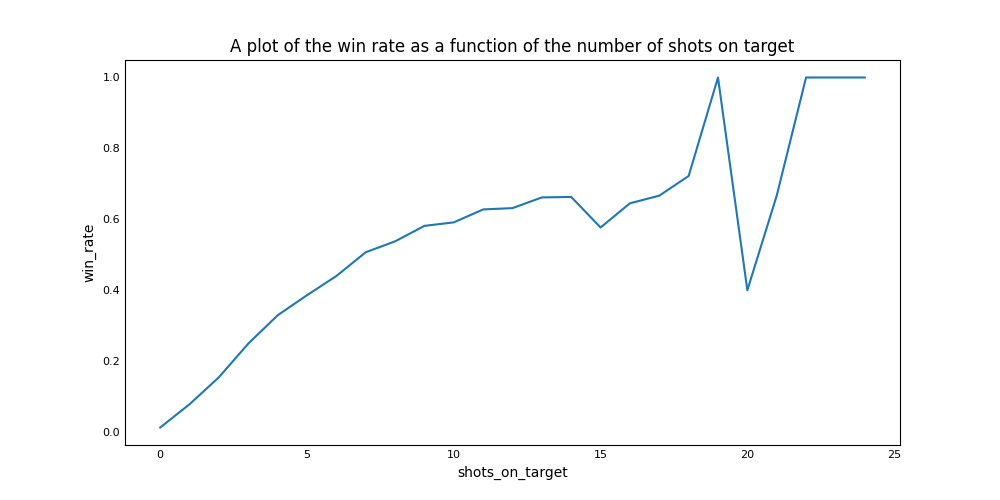

In [13]:
# Calculate the chance of a team winning the match as a function of number of shots made
shots_on_target_data = []
for _, row in train_df.iterrows():
    shots_on_target_data.append(
        (row["home_shots_on_target"], row["full_time_result"] == "H")
    )
    shots_on_target_data.append(
        (row["away_shots_on_target"], row["full_time_result"] == "A")
    )

shots_on_target_df = (
    pd.DataFrame(shots_on_target_data, columns=["shots_on_target", "win_rate"])
    .groupby("shots_on_target")
    .mean()
)

# Plot the relationship
fig = plt.figure(figsize=(10, 5))
ax0 = fig.add_subplot()
sns.lineplot(
    data=shots_on_target_df, x="shots_on_target", y="win_rate", ax=ax0, legend=False
)
ax0.set_title("A plot of the win rate as a function of the number of shots on target")
ax0.tick_params(axis="both", which="major", labelsize=8)
ax0.tick_params(axis="both", which="both", length=0)

plt.show()

As the number of shots on target increases, the win rate also increases, as you might expect, so it likely to be a good feature to use. What other relationships might you want to investigate?

In [14]:
# EXERCISE: produce a correlation matrix for the features in the training set

## Data Preprocessing

We can now move onto preprocessing our data to prepare it for use in training. Here, we are looking to do things such as scaling our numerical data, encoding our categorical data and possibly even engineering some features! If you are interested in learning more about data preprocessing, check out the [scikit-learn documentation](https://scikit-learn.org/stable/modules/preprocessing.html) on the subject. Just note that you will want to preprocess the test set in the same way, so if you scale your training data, you will want to scale your test data in the same way (with the same parameters)!

### Dropping unneeded columns

For the example model we are going to train in this notebook, we are only using a subset of the features in the training set. Figuring out how to incorporate the rest is your challenge! 😉

With that in mind, we can start by dropping all the columns in our dataset we are not going to use this time around.

In [15]:
train_df.drop(
    columns=[
        "date",
        "full_time_home_goals",
        "full_time_away_goals",
        "half_time_home_goals",
        "half_time_away_goals",
        "half_time_result",
        "referee",
    ],
    inplace=True,
)

In [16]:
train_df.columns

Index(['home_team', 'away_team', 'full_time_result', 'home_shots',
       'away_shots', 'home_shots_on_target', 'away_shots_on_target',
       'home_fouls', 'away_fouls', 'home_corners', 'away_corners',
       'home_yellow_cards', 'away_yellow_cards', 'home_red_cards',
       'away_red_cards'],
      dtype='object')

### Feature engineering

You might wish to engineer a few features of your own, such as calculating the proportion of shots on target. Here is a good place to do so!

In [17]:
# EXERCISE: engineer some of your own features!

### Transforming the data

Since we want to apply the same column transformations we do on the training set to the test set, we can construct a `ColumnTransformer` to make this process easier for us.

What data transformations might we want to perform?

- **Scaling numerical features**: there are many different data scaling techniques you can apply to the numerical features in our training dataset, such as scaling the features to some range (e.g. `[0, 1]`) or standardisation (removing the mean and rescaling to unit variance). Some approaches might be more suitable than others, depending on what you are trying to achieve and the models you are using. This time around, we will take the first approach, but it is a good idea to experiment to see what gives you better results!

- **Encoding categorical features**: we cannot train our machine learning models directly on the categorical data, so we need to encode it first, such as by using a one-hot encoding. You might want to explore what other encoding methods exist and the situations where they are the most suitable.

- **Dimensionality reduction**: as a result of the _curse of dimensionality_, it can become harder to train models as the number of features increases, so you might want to apply techniques, such as [principal component analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (PCA) to reduce the dimensionality of the data.

- **Separating the features and labels**: we definitely want to make sure we separate the input features from our output label so that we do not end up training on what we are trying to predict!

Most `scikit-learn` classifiers will automatically encode labels for us, so we can skip this step for now, but if you want to apply a neural network trained with `TensorFlow` or `PyTorch` to this problem, you will have to do this.


In [18]:
numeric_features = [
    "home_shots",
    "away_shots",
    "home_shots_on_target",
    "away_shots_on_target",
    "home_fouls",
    "away_fouls",
    "home_corners",
    "away_corners",
    "home_yellow_cards",
    "away_yellow_cards",
    "home_red_cards",
    "away_red_cards",
]

transformer = make_column_transformer(
    (MinMaxScaler(), numeric_features),
    (OneHotEncoder(), ["home_team", "away_team"]),
    # OPTIONAL EXERCISE: add PCA
)

X = transformer.fit_transform(train_df.drop(columns=["full_time_result"]))
y = train_df["full_time_result"]

## Model Selection, Training & Evaluation

This is where the magic happens: selecting, training and evaluating machine learning models. 

### A little theory

Recall that we are trying to develop a model with the lowest **generalisation error** (or **out-of-sample error**), which is a measure of how well our model performs on unseen data. Of course, we cannot compute this directly &ndash; the data is unseen! &ndash; so we use the **empirical error** from evaluating the model on a test set, which is not used in training at all, as a proxy. This is what we show on the [DOXA scoreboard](https://doxaai.com/competition/epl).

In the ideal scenario, our model will generalise to perform similarly on both the training and test sets; however, this is not always the case. If our model starts to fit to the noise (or residual variation) in our training dataset, rather than the underlying function we are trying to learn (the signal), we end up with **overfitting**; and likewise, if the representation of our model is not rich enough to encode the true underlying relationship in the data, our model ends up **underfitting**. Both issues cause our model to perform worse when evaluated out-of-sample.

There are a lot of different models available to us, each with a range of **hyperparameters** we can tune to affect the learning process; however, if we use the performance of our models on the test set as the basis for updating hyperparameters, we stand the real chance of leaking information about and overfitting to the test set.

One approach is to further subdivide our training dataset into a training set and a completely separate **validation set**, but training data is precious a lot of the time, and we would not want to overfit to that too. An alternative approach here is to perform (**stratified**) **k-fold cross-validation**, where we (randomly) partition the data into `k` "folds", train `k` models using each fold for validation and the remaining folds for training, and average the results. You can read more about this in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/cross_validation.html).

Putting this all together, we finally just need a strategy for optimising our hyperparameters. One (albeit potentially slow) way is just to perform a **cross-validated grid search** over a grid of hyperparameter values we want to investigate in order to try out a range of different combinations. When we think we have found the model with the best set of hyperparameters, we can retrain it on all of the training data and then evaluate it on the test set. Bam! 😎

### Putting everything into practice

We can now try applying what we know by performing a small grid search of our own on a [linear support vector classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) (or `LinearSVC`) to find the value of the hyperparameter `C` (which controls the strength of regularisation that is applied) that gives the best performing model!

In [19]:
parameter_grid = {
    "C": [0.1, 1, 10],
    # you can add more parameters here!
}

classifier = GridSearchCV(LinearSVC(max_iter=2000), parameter_grid, scoring="f1_micro")
classifier.fit(X, y)

print("Best parameters:", classifier.best_params_)
print("Best micro-averaged F1 score:", classifier.best_score_)

Best parameters: {'C': 0.1}
Best micro-averaged F1 score: 0.5711915535444948


Neat! We just used [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to perform a cross-validated grid search and automatically retrain the model on all of the training data, which we could now use to make predictions for the test set if we so wanted. A score of 57% is really not bad for our first attempt &ndash; this is not an easy problem!

Now, it is your turn &ndash; try performing grid searches for other model types, such as [decision tree classifiers](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [logistic regression models](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), [support vector machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) with non-linear kernels, and [random forest classifiers](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)! How much better can you do?

In [20]:
# EXERCISE: try out a grid search of your own!

But hang on a minute &ndash; what is a "micro-averaged F1 score" that we are using to evaluate our models?

### Evaluation metrics

There are several different metrics we can use to evaluate the performance of a classifier, most notably **accuracy**; however, accuracy can sometimes be misleading when evaluating on an imbalanced dataset, since it does not take the distribution of the classes into account. Here, there is a clear home advantage, so we might want to consider other metrics.

In a binary classification setting, where we have trained a model to classify examples as belonging to either a positive class or a negative class, **true positives** (TP) and **true negatives** (TN) are outcomes that have been correctly classified by our model. Likewise, **false positives** (FN) and **false negatives** (FN) represent outcomes that have been incorrectly classified as positive and negative, respectively.

**Precision** &ndash; also known as the **positive predictive value** (PPV) &ndash; is the proportion of positive predictions that were correctly classified:

\begin{equation*}
    \text{precision} = \frac{TP}{TP + FP}
\end{equation*}

**Recall** &ndash; also known as the **true positive rate** (TPR) or in the binary setting, **sensitivity** &ndash; is the proportion of true positive examples that were correctly classified by the model:

\begin{equation*}
    \text{recall} = \frac{TP}{TP + FN}
\end{equation*}

An **F<sub>1</sub> score** combines both precision and recall by taking their harmonic mean:

\begin{equation*}
    F_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}} = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}
\end{equation*}

Depending on our objectives, this can make it a useful metric for evaluating the performance of a classifier. Note that as we can see from the equation, it takes true positives, false positives and false negatives into account (but not true negatives).

Now, this is interesting for binary classification, but our challenge is that of multi-class classification, so what can we do to extend these metrics for binary classification to the multi-class setting?

- **Macro-averaging** calculates the metric for each class separately (taking a one-versus-rest approach) and then takes an unweighted mean of the results, weighing each class equally.
- **Micro-averaging** aggregates the prediction outcomes across all classes to calculate the metric, weighing each sample equally.

For this challenge, we decided to go with the micro-averaged F<sub>1</sub> score given the imbalanced nature of the problem arising from the home advantage phenomenon.

### Plotting a confusion matrix

A **confusion matrix** is a way to visualise a summary of the predictions made by the classifier we trained. Note that correctly predicted labels appear on the diagonal!

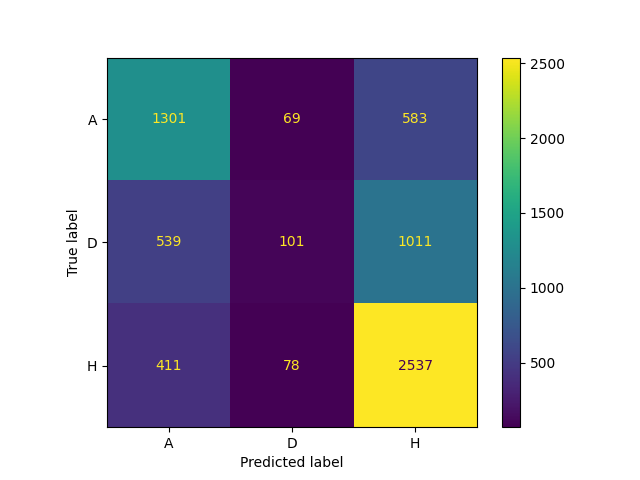

In [21]:
ConfusionMatrixDisplay.from_predictions(y_true=y, y_pred=classifier.predict(X))

## Preparing our DOXA Submission

Once we are content with the performance of our model, we can apply it to the test set and submit its predictions to DOXA! 

We just need to transform the test set features the same way we transformed the training set earlier on before we can feed everything into our trained classifier.

In [22]:
# Drop columns we do not need
test_df.drop(columns=["date", "referee"], inplace=True)

# Transform the test set
X_test = transformer.transform(test_df)

# Use our trained classifier to make predictions
predictions = classifier.predict(X_test)

We can quickly look at a few of the resulting predictions just to make sure that the output is relatively sane.

In [23]:
predictions[:20]

array(['A', 'H', 'A', 'A', 'H', 'H', 'H', 'H', 'H', 'A', 'H', 'A', 'H',
       'H', 'H', 'H', 'H', 'H', 'H', 'H'], dtype=object)

We can also check that the number of predictions matches what we expect.

In [24]:
predictions.shape

(736,)

Neat! Everything looks good &ndash; the output is exactly the shape it should be with 736 entries, so we are ready to prepare our submission package and upload our predictions to DOXA for evaluation on the test set.

In [ ]:
os.makedirs("submission", exist_ok=True)

with open("submission/y.txt", "w") as f:
    f.writelines([f"{prediction}\n" for prediction in predictions])

with open("submission/doxa.yaml", "w") as f:
    f.write("competition: epl\nenvironment: cpu\nlanguage: python\nentrypoint: run.py")

with open("submission/run.py", "w") as f:
    f.write("with open('y.txt', 'r') as f: print(f.read().strip())")

## Submitting to DOXA

Before you can submit to DOXA, you must first ensure that you are enrolled for the challenge on the DOXA website. Visit [the challenge page](https://doxaai.com/competition/uclais-1) and click "Enrol" in the top-right corner if you have not done so already.

You can then log in using the DOXA CLI by running the following command:

In [ ]:
!doxa login

Finally, you can submit your results to DOXA by running the following command:

In [ ]:
!doxa upload submission

Wooo! 🥳 You have (probably) just uploaded your English Premier League match result predictions to DOXA &ndash; well done! Take a moment to see how you have done on the [scoreboard](https://doxaai.com/competition/epl).

## Possible Improvements & Reflections

Congratulations &ndash; you have made it to the end! We hope you have enjoyed learning about and applying machine learning to this challenge. Hopefully, you can now start experimenting with your own ideas to see how you can improve the performance of your model!

Here are a few ideas to get you started on making improvements:

**1. Data Collection**
- You are more than welcome to try sourcing and cleaning additional data (such as individual player rating data or even shot-level data) to help you train your model &ndash; just be careful not to accidentally train on what we are trying to predict.

**2. Data Visualisation**
- Visualise other features as well (beyond just shots on target) to see what other features correlate well with the chance of a team winning. If there are any features that do not correlate particularly well with the chance of a team winning, perhaps it should be removed.
- Produce a correlation matrix to do this all in a single visualisation.

**3. Data Preprocessing**
- Apply the [PCA algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the dimensionality of our data by projecting each input sample onto a lower dimensional subspace while trying to maximally preserve the variation in the data. The number of components you pick is a hyperparameter that you can tune.
- Determine how you can incorporate dates into the model; teams are likely to vary in performance over time.
- Explore how you could implement [Elo ratings](https://blog.collegefootballdata.com/talking-tech-elo-ratings/) to track the performance of a team each season.
- Experiment with creating other offensive and defensive metrics of your own!

**4. Model Selection**
- Try out a wider selection of model types beyond those listed in the notebook, such as [gradient boosting classifiers](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and [ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html).
- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) is not your only option, other hyperparameter optimisers are availabe in `scikit-learn`, such as [HalvingGridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) and [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).
- Check out using [BayesSearchCV](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html) from the [scikit-optimize](https://scikit-optimize.github.io/stable/) package, which searches the space of hyperparameters using Bayesian optimisation and is a drop-in replacement for [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

## Closing Remarks

In a more realistic scenario, you might instead want to build a model to predict the outcomes of future matches, rather than the results of past ones (which you could probably look up!); moreover, the test set would only contain features we could know in advance of the match happening, such as `date` (where dates are in the future), `home_team` and `away_team`. How might you be able to adapt the model we have been building together to predict future match results?

To conclude, we hope that you have found this to be a useful and enjoyable exercise in exploring and gaining exposure to some fascinating ideas and concepts in machine learning. We look forward to seeing what you build! Do continue the conversation on the [DOXA Community Discord server](https://discord.gg/MUvbQ3UYcf). 😎